In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda

from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import wandb

2023-02-08 14:13:51.414806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 14:13:51.522844: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# kaggle의 data를 가져오기

In [2]:
!pip install opendatasets


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import opendatasets as od

In [4]:
dataset = 'https://www.kaggle.com/datasets/veeralakrishna/200-bird-species-with-11788-images'

### kaggle username과 key는 kaggle의 Create New API Token에서 json파일을 받아와 입력

In [5]:
od.download(dataset)

Skipping, found downloaded files in "./200-bird-species-with-11788-images" (use force=True to force download)


In [6]:
import os

In [7]:
data_dir = './200-bird-species-with-11788-images'

In [8]:
os.listdir(data_dir)

['CUB_200_2011.tgz', 'segmentations.tgz']

### data_dir = './200-bird-species-with-11788-images' 경로에 있는 tgz파일 압축해제

In [9]:
!tar xvzf ./200-bird-species-with-11788-images/CUB_200_2011.tgz

attributes.txt
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0036_796127.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0069_796139.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg
CUB_200_2011/images/001.Black_footed_Albat

In [2]:
from pathlib import Path

PATH = Path('./CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
labels

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
11783,11784,200
11784,11785,200
11785,11786,200
11786,11787,200


In [3]:
train_test = pd.read_csv(PATH/"train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]
train_test

,id,is_train
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1
...,...,...
11783,11784,1
11784,11785,0
11785,11786,0
11786,11787,1


In [4]:
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "bird_name"]
images

,id,bird_name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...
...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...


In [5]:
classes = pd.read_csv(PATH/"classes.txt", header=None, sep=" ")
classes.columns = ["id", "class"]
classes

,id,class
0,1,001.Black_footed_Albatross
1,2,002.Laysan_Albatross
2,3,003.Sooty_Albatross
3,4,004.Groove_billed_Ani
4,5,005.Crested_Auklet
...,...,...
195,196,196.House_Wren
196,197,197.Marsh_Wren
197,198,198.Rock_Wren
198,199,199.Winter_Wren


In [6]:
df_1 = pd.merge(images, labels, on='id')
df_1 

,id,bird_name,label
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1
...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,200
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,200
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,200
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,200


In [7]:
df = pd.merge(df_1, train_test, on='id')
df

,id,bird_name,label,is_train
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1
...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,1
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,0
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,0
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,1


In [8]:
df.loc[0]

id                                                           1
bird_name    001.Black_footed_Albatross/Black_Footed_Albatr...
label                                                        1
is_train                                                     0
Name: 0, dtype: object

In [9]:
train, test = [], []

In [10]:
train_test = df.iloc[:,-1]
train_test

0        0
1        1
2        0
3        1
4        1
        ..
11783    1
11784    0
11785    0
11786    1
11787    0
Name: is_train, Length: 11788, dtype: int64

In [11]:
for i in range(len(df)):
    if train_test[i] == 0:
        train.append(df.loc[i])
    else:
        test.append(df.loc[i])

In [12]:
train = pd.DataFrame(train)
train

,id,bird_name,label,is_train
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0
5,6,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0
9,10,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0
11,12,001.Black_footed_Albatross/Black_Footed_Albatr...,1,0
...,...,...,...,...
11779,11780,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,0
11782,11783,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,0
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,0
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,0


In [13]:
test = pd.DataFrame(test)
test

,id,bird_name,label,is_train
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1
6,7,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1
7,8,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1
...,...,...,...,...
11777,11778,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,1
11780,11781,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,1
11781,11782,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,1
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,1


In [14]:
def preprocessing(image):
    resized_image = tf.image.resize(image, [224,224])
    return tf.keras.applications.resnet50.preprocess_input(resized_image)

## train 전처리

In [15]:
X_train, y_train = [], []
path = ''

for i, row in train.iterrows():
    bird_name = row['bird_name']
    label = row['label']
    path = f'./CUB_200_2011/images/{bird_name}'
    img = plt.imread(path)
    
    if len(img.shape) == 3 or len(img.shape) == 4:
        img = preprocessing(img)
        X_train.append(img)
        y_train.append(label)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

y_train = tf.keras.utils.to_categorical(y_train)

2023-02-08 14:14:06.626083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 14:14:06.629383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 14:14:06.629741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 14:14:06.630442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
X_train.shape

(5790, 224, 224, 3)

In [17]:
y_train.shape

(5790, 201)


## test 전처리

In [19]:
X_test, y_test = [], []
path = ''

for id, row in test.iterrows():
    bird_name = row['bird_name']
    label = row['label']
    path = f'./CUB_200_2011/images/{bird_name}'
    img = plt.imread(path)
    
    if len(img.shape) == 3 or len(img.shape) == 4:
        img = preprocessing(img)
        X_test.append(img)
        y_test.append(label)
X_test = np.array(X_test)
y_test = np.array(y_test)       
y_test = tf.keras.utils.to_categorical (y_test)

In [20]:
X_test.shape

(5990, 224, 224, 3)

## validation set 생성

In [21]:
from sklearn.model_selection import train_test_split

X_tn, X_val, y_tn, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [22]:
X_tn.shape

(4921, 224, 224, 3)

In [23]:
X_val.shape

(869, 224, 224, 3)

In [24]:
y_val.shape

(869, 201)

In [ ]:
wandb.init(project="Bird", entity="hcim", name='Bird_14')

from tensorflow.keras import callbacks
class WandbCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        wandb.log(logs)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chan4im (hcim). Use `wandb login --relogin` to force relogin


## Model 생성  _ VGG19을 base로 생성

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Activation, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras import regularizers



vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='avg')

x = Flatten()(vgg.output)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(201, activation='softmax')(x)

model = Model(vgg.input, output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [31]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_tn)

In [32]:
import tensorflow_addons.metrics
from tensorflow.keras.optimizers import SGD
optimizer = SGD(learning_rate=0.0039)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(),tensorflow_addons.metrics.F1Score(num_classes=201, average='macro')]) 

In [ ]:
hist = model.fit_generator(datagen.flow(X_tn, y_tn, batch_size=16), epochs=800, validation_data=(X_val, y_val), callbacks=[WandbCallback()])

Epoch 1/800


/tmp/ipykernel_1210/1117950546.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_tn, y_tn, batch_size=16), epochs=800, validation_data=(X_val, y_val), callbacks=[WandbCallback()])
2023-02-08 14:18:30.394779: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


308/308 [==============================] - 45s 134ms/step - loss: 5.3397 - categorical_accuracy: 0.0053 - f1_score: 0.0033 - val_loss: 5.3042 - val_categorical_accuracy: 0.0035 - val_f1_score: 1.2033e-04
Epoch 2/800
308/308 [==============================] - 37s 118ms/step - loss: 5.3033 - categorical_accuracy: 0.0047 - f1_score: 0.0032 - val_loss: 5.3041 - val_categorical_accuracy: 0.0058 - val_f1_score: 0.0020
Epoch 3/800
308/308 [==============================] - 36s 117ms/step - loss: 5.3029 - categorical_accuracy: 0.0049 - f1_score: 0.0025 - val_loss: 5.3042 - val_categorical_accuracy: 0.0069 - val_f1_score: 0.0022
Epoch 4/800
308/308 [==============================] - 36s 117ms/step - loss: 5.3026 - categorical_accuracy: 0.0063 - f1_score: 0.0043 - val_loss: 5.3039 - val_categorical_accuracy: 0.0023 - val_f1_score: 6.9525e-04
Epoch 5/800
308/308 [==============================] - 36s 116ms/step - loss: 5.3012 - categorical_accuracy: 0.0065 - f1_score: 0.0032 - val_loss: 5.3017 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 120ms/step - loss: 3.2415 - categorical_accuracy: 0.3052 - f1_score: 0.2611 - val_loss: 3.4766 - val_categorical_accuracy: 0.2716 - val_f1_score: 0.2328
Epoch 48/800
308/308 [==============================] - 38s 122ms/step - loss: 2.8023 - categorical_accuracy: 0.4009 - f1_score: 0.3551 - val_loss: 3.1934 - val_categorical_accuracy: 0.3257 - val_f1_score: 0.2755
Epoch 53/800
308/308 [==============================] - 37s 120ms/step - loss: 2.7241 - categorical_accuracy: 0.4170 - f1_score: 0.3726 - val_loss: 3.1574 - val_categorical_accuracy: 0.3303 - val_f1_score: 0.2995
Epoch 54/800
308/308 [==============================] - 37s 121ms/step - loss: 2.6003 - categorical_accuracy: 0.4345 - f1_score: 0.3902 - val_loss: 2.9928 - val_categorical_accuracy: 0.3533 - val_f1_score: 0.3155
Epoch 55/800
308/308 [==============================] - 38s 123ms/step - loss: 2.5387 - categorical_accuracy: 0.4357 - f1_score: 0.4013 - val_loss: 2.9668 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 38s 122ms/step - loss: 0.4712 - categorical_accuracy: 0.8608 - f1_score: 0.8546 - val_loss: 2.0457 - val_categorical_accuracy: 0.5995 - val_f1_score: 0.5694
Epoch 89/800
308/308 [==============================] - 37s 118ms/step - loss: 0.4501 - categorical_accuracy: 0.8740 - f1_score: 0.8683 - val_loss: 1.9761 - val_categorical_accuracy: 0.6191 - val_f1_score: 0.5784
Epoch 90/800
308/308 [==============================] - 37s 121ms/step - loss: 0.3976 - categorical_accuracy: 0.8893 - f1_score: 0.8833 - val_loss: 2.0879 - val_categorical_accuracy: 0.6168 - val_f1_score: 0.5883
Epoch 93/800
308/308 [==============================] - 37s 120ms/step - loss: 0.3245 - categorical_accuracy: 0.9043 - f1_score: 0.8981 - val_loss: 2.0705 - val_categorical_accuracy: 0.6145 - val_f1_score: 0.5773
Epoch 94/800
308/308 [==============================] - 38s 121ms/step - loss: 0.3131 - categorical_accuracy: 0.9067 - f1_score: 0.9008 - val_loss: 2.0542 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 120ms/step - loss: 0.1243 - categorical_accuracy: 0.9673 - f1_score: 0.9620 - val_loss: 2.1653 - val_categorical_accuracy: 0.6306 - val_f1_score: 0.6011
Epoch 118/800
308/308 [==============================] - 38s 122ms/step - loss: 0.1303 - categorical_accuracy: 0.9661 - f1_score: 0.9604 - val_loss: 2.0443 - val_categorical_accuracy: 0.6226 - val_f1_score: 0.5958
Epoch 119/800
308/308 [==============================] - 37s 119ms/step - loss: 0.1647 - categorical_accuracy: 0.9541 - f1_score: 0.9487 - val_loss: 2.1070 - val_categorical_accuracy: 0.6145 - val_f1_score: 0.5798
Epoch 120/800
308/308 [==============================] - 38s 122ms/step - loss: 0.1711 - categorical_accuracy: 0.9579 - f1_score: 0.9524 - val_loss: 2.3023 - val_categorical_accuracy: 0.6133 - val_f1_score: 0.5846
Epoch 125/800
308/308 [==============================] - 37s 120ms/step - loss: 0.1650 - categorical_accuracy: 0.9543 - f1_score: 0.9484 - val_loss: 2.2563 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 120ms/step - loss: 0.0671 - categorical_accuracy: 0.9821 - f1_score: 0.9769 - val_loss: 2.2135 - val_categorical_accuracy: 0.6571 - val_f1_score: 0.6253
Epoch 151/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0446 - categorical_accuracy: 0.9860 - f1_score: 0.9802 - val_loss: 2.2479 - val_categorical_accuracy: 0.6548 - val_f1_score: 0.6354
Epoch 152/800
308/308 [==============================] - 37s 120ms/step - loss: 0.4465 - categorical_accuracy: 0.9140 - f1_score: 0.9129 - val_loss: 2.3366 - val_categorical_accuracy: 0.5570 - val_f1_score: 0.5258
Epoch 153/800
308/308 [==============================] - 37s 120ms/step - loss: 0.2327 - categorical_accuracy: 0.9392 - f1_score: 0.9331 - val_loss: 1.9608 - val_categorical_accuracy: 0.6444 - val_f1_score: 0.6164
Epoch 154/800
308/308 [==============================] - 37s 118ms/step - loss: 0.0820 - categorical_accuracy: 0.9774 - f1_score: 0.9724 - val_loss: 2.2698 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 38s 123ms/step - loss: 0.0271 - categorical_accuracy: 0.9917 - f1_score: 0.9868 - val_loss: 2.3655 - val_categorical_accuracy: 0.6306 - val_f1_score: 0.6083
Epoch 175/800
308/308 [==============================] - 36s 118ms/step - loss: 0.0398 - categorical_accuracy: 0.9904 - f1_score: 0.9851 - val_loss: 2.3961 - val_categorical_accuracy: 0.6490 - val_f1_score: 0.6238
Epoch 179/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0346 - categorical_accuracy: 0.9898 - f1_score: 0.9851 - val_loss: 2.2646 - val_categorical_accuracy: 0.6479 - val_f1_score: 0.6211
Epoch 180/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0503 - categorical_accuracy: 0.9850 - f1_score: 0.9799 - val_loss: 2.3076 - val_categorical_accuracy: 0.6318 - val_f1_score: 0.6114
Epoch 181/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0336 - categorical_accuracy: 0.9888 - f1_score: 0.9835 - val_loss: 2.1978 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 119ms/step - loss: 0.0310 - categorical_accuracy: 0.9915 - f1_score: 0.9865 - val_loss: 2.4007 - val_categorical_accuracy: 0.6525 - val_f1_score: 0.6155
Epoch 204/800
308/308 [==============================] - 38s 123ms/step - loss: 0.0444 - categorical_accuracy: 0.9886 - f1_score: 0.9840 - val_loss: 2.2473 - val_categorical_accuracy: 0.6674 - val_f1_score: 0.6461
Epoch 205/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0169 - categorical_accuracy: 0.9953 - f1_score: 0.9903 - val_loss: 2.2456 - val_categorical_accuracy: 0.6559 - val_f1_score: 0.6272
Epoch 206/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0188 - categorical_accuracy: 0.9955 - f1_score: 0.9904 - val_loss: 2.2183 - val_categorical_accuracy: 0.6812 - val_f1_score: 0.6543
Epoch 207/800
308/308 [==============================] - 38s 123ms/step - loss: 0.0188 - categorical_accuracy: 0.9935 - f1_score: 0.9885 - val_loss: 2.3280 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 120ms/step - loss: 0.0244 - categorical_accuracy: 0.9935 - f1_score: 0.9883 - val_loss: 2.3600 - val_categorical_accuracy: 0.6559 - val_f1_score: 0.6220
Epoch 230/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0143 - categorical_accuracy: 0.9951 - f1_score: 0.9898 - val_loss: 2.2741 - val_categorical_accuracy: 0.6640 - val_f1_score: 0.6379
Epoch 231/800
308/308 [==============================] - 38s 123ms/step - loss: 0.0080 - categorical_accuracy: 0.9980 - f1_score: 0.9930 - val_loss: 2.5812 - val_categorical_accuracy: 0.6582 - val_f1_score: 0.6258
Epoch 232/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0235 - categorical_accuracy: 0.9941 - f1_score: 0.9890 - val_loss: 2.3323 - val_categorical_accuracy: 0.6444 - val_f1_score: 0.6105
Epoch 233/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0516 - categorical_accuracy: 0.9870 - f1_score: 0.9819 - val_loss: 2.4006 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 121ms/step - loss: 0.0300 - categorical_accuracy: 0.9919 - f1_score: 0.9869 - val_loss: 2.4159 - val_categorical_accuracy: 0.6306 - val_f1_score: 0.6129
Epoch 279/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0198 - categorical_accuracy: 0.9955 - f1_score: 0.9906 - val_loss: 2.2277 - val_categorical_accuracy: 0.6663 - val_f1_score: 0.6391
Epoch 280/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0112 - categorical_accuracy: 0.9980 - f1_score: 0.9931 - val_loss: 2.3188 - val_categorical_accuracy: 0.6778 - val_f1_score: 0.6461
Epoch 281/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0088 - categorical_accuracy: 0.9974 - f1_score: 0.9924 - val_loss: 2.3047 - val_categorical_accuracy: 0.6559 - val_f1_score: 0.6327
Epoch 285/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0122 - categorical_accuracy: 0.9963 - f1_score: 0.9912 - val_loss: 2.5032 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 120ms/step - loss: 0.0130 - categorical_accuracy: 0.9972 - f1_score: 0.9921 - val_loss: 2.3980 - val_categorical_accuracy: 0.6743 - val_f1_score: 0.6498
Epoch 301/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0061 - categorical_accuracy: 0.9978 - f1_score: 0.9926 - val_loss: 2.3447 - val_categorical_accuracy: 0.6893 - val_f1_score: 0.6561
Epoch 305/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0143 - categorical_accuracy: 0.9978 - f1_score: 0.9926 - val_loss: 2.3928 - val_categorical_accuracy: 0.6789 - val_f1_score: 0.6515
Epoch 306/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0203 - categorical_accuracy: 0.9963 - f1_score: 0.9913 - val_loss: 2.3786 - val_categorical_accuracy: 0.6433 - val_f1_score: 0.6148
Epoch 307/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0253 - categorical_accuracy: 0.9951 - f1_score: 0.9899 - val_loss: 2.2724 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 121ms/step - loss: 0.0157 - categorical_accuracy: 0.9959 - f1_score: 0.9908 - val_loss: 2.2868 - val_categorical_accuracy: 0.6812 - val_f1_score: 0.6602
Epoch 359/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0069 - categorical_accuracy: 0.9984 - f1_score: 0.9935 - val_loss: 2.3635 - val_categorical_accuracy: 0.6709 - val_f1_score: 0.6442
Epoch 360/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0154 - categorical_accuracy: 0.9972 - f1_score: 0.9922 - val_loss: 2.3586 - val_categorical_accuracy: 0.6513 - val_f1_score: 0.6261
Epoch 361/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0148 - categorical_accuracy: 0.9961 - f1_score: 0.9909 - val_loss: 2.4076 - val_categorical_accuracy: 0.6387 - val_f1_score: 0.6044
Epoch 362/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0161 - categorical_accuracy: 0.9947 - f1_score: 0.9896 - val_loss: 2.4112 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 121ms/step - loss: 0.0025 - categorical_accuracy: 0.9990 - f1_score: 0.9939 - val_loss: 2.5098 - val_categorical_accuracy: 0.6789 - val_f1_score: 0.6562
Epoch 383/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0060 - categorical_accuracy: 0.9982 - f1_score: 0.9931 - val_loss: 2.5966 - val_categorical_accuracy: 0.6640 - val_f1_score: 0.6353
Epoch 385/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0020 - categorical_accuracy: 0.9994 - f1_score: 0.9944 - val_loss: 2.7516 - val_categorical_accuracy: 0.6674 - val_f1_score: 0.6421
Epoch 386/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0152 - categorical_accuracy: 0.9965 - f1_score: 0.9916 - val_loss: 2.5858 - val_categorical_accuracy: 0.6214 - val_f1_score: 0.5901
Epoch 387/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0208 - categorical_accuracy: 0.9953 - f1_score: 0.9905 - val_loss: 2.2485 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 38s 122ms/step - loss: 0.0045 - categorical_accuracy: 0.9988 - f1_score: 0.9935 - val_loss: 2.4345 - val_categorical_accuracy: 0.6582 - val_f1_score: 0.6363
Epoch 438/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0019 - categorical_accuracy: 0.9996 - f1_score: 0.9945 - val_loss: 2.5308 - val_categorical_accuracy: 0.6801 - val_f1_score: 0.6486
Epoch 442/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0040 - categorical_accuracy: 0.9986 - f1_score: 0.9936 - val_loss: 2.5664 - val_categorical_accuracy: 0.7008 - val_f1_score: 0.6737
Epoch 443/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0056 - categorical_accuracy: 0.9982 - f1_score: 0.9931 - val_loss: 2.6541 - val_categorical_accuracy: 0.6847 - val_f1_score: 0.6631
Epoch 444/800
308/308 [==============================] - 38s 123ms/step - loss: 0.0108 - categorical_accuracy: 0.9965 - f1_score: 0.9913 - val_loss: 2.5873 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 38s 122ms/step - loss: 0.0080 - categorical_accuracy: 0.9976 - f1_score: 0.9926 - val_loss: 2.3595 - val_categorical_accuracy: 0.6686 - val_f1_score: 0.6496
Epoch 464/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0056 - categorical_accuracy: 0.9986 - f1_score: 0.9936 - val_loss: 2.4861 - val_categorical_accuracy: 0.6824 - val_f1_score: 0.6570
Epoch 467/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0070 - categorical_accuracy: 0.9984 - f1_score: 0.9933 - val_loss: 2.4774 - val_categorical_accuracy: 0.6720 - val_f1_score: 0.6428
Epoch 468/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0041 - categorical_accuracy: 0.9982 - f1_score: 0.9930 - val_loss: 2.5735 - val_categorical_accuracy: 0.6743 - val_f1_score: 0.6472
Epoch 469/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0137 - categorical_accuracy: 0.9961 - f1_score: 0.9912 - val_loss: 2.3816 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 119ms/step - loss: 0.0544 - categorical_accuracy: 0.9925 - f1_score: 0.9875 - val_loss: 2.3238 - val_categorical_accuracy: 0.6548 - val_f1_score: 0.6266
Epoch 543/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0060 - categorical_accuracy: 0.9984 - f1_score: 0.9934 - val_loss: 2.4809 - val_categorical_accuracy: 0.6755 - val_f1_score: 0.6441
Epoch 547/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0209 - categorical_accuracy: 0.9961 - f1_score: 0.9912 - val_loss: 2.1475 - val_categorical_accuracy: 0.6513 - val_f1_score: 0.6204
Epoch 548/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0135 - categorical_accuracy: 0.9976 - f1_score: 0.9925 - val_loss: 2.4566 - val_categorical_accuracy: 0.6571 - val_f1_score: 0.6294
Epoch 549/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0080 - categorical_accuracy: 0.9967 - f1_score: 0.9916 - val_loss: 2.4609 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 38s 121ms/step - loss: 0.0050 - categorical_accuracy: 0.9984 - f1_score: 0.9933 - val_loss: 2.3386 - val_categorical_accuracy: 0.6720 - val_f1_score: 0.6450
Epoch 622/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0029 - categorical_accuracy: 0.9990 - f1_score: 0.9939 - val_loss: 2.5925 - val_categorical_accuracy: 0.6928 - val_f1_score: 0.6649
Epoch 626/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0167 - categorical_accuracy: 0.9963 - f1_score: 0.9913 - val_loss: 2.3555 - val_categorical_accuracy: 0.6479 - val_f1_score: 0.6221
Epoch 627/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0049 - categorical_accuracy: 0.9984 - f1_score: 0.9935 - val_loss: 2.1778 - val_categorical_accuracy: 0.6928 - val_f1_score: 0.6656
Epoch 628/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0040 - categorical_accuracy: 0.9992 - f1_score: 0.9942 - val_loss: 2.2620 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 120ms/step - loss: 0.0042 - categorical_accuracy: 0.9988 - f1_score: 0.9938 - val_loss: 2.4453 - val_categorical_accuracy: 0.6824 - val_f1_score: 0.6536
Epoch 654/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0047 - categorical_accuracy: 0.9990 - f1_score: 0.9940 - val_loss: 2.5168 - val_categorical_accuracy: 0.6502 - val_f1_score: 0.6221
Epoch 655/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0218 - categorical_accuracy: 0.9955 - f1_score: 0.9907 - val_loss: 2.4785 - val_categorical_accuracy: 0.6099 - val_f1_score: 0.5829
Epoch 656/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0124 - categorical_accuracy: 0.9976 - f1_score: 0.9926 - val_loss: 2.2395 - val_categorical_accuracy: 0.6640 - val_f1_score: 0.6404
Epoch 657/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0048 - categorical_accuracy: 0.9988 - f1_score: 0.9937 - val_loss: 2.2954 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 121ms/step - loss: 0.0022 - categorical_accuracy: 0.9990 - f1_score: 0.9939 - val_loss: 2.6078 - val_categorical_accuracy: 0.6651 - val_f1_score: 0.6299
Epoch 677/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0047 - categorical_accuracy: 0.9990 - f1_score: 0.9938 - val_loss: 2.6713 - val_categorical_accuracy: 0.6663 - val_f1_score: 0.6431
Epoch 681/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0014 - categorical_accuracy: 0.9996 - f1_score: 0.9946 - val_loss: 2.9024 - val_categorical_accuracy: 0.6617 - val_f1_score: 0.6334
Epoch 682/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0062 - categorical_accuracy: 0.9980 - f1_score: 0.9930 - val_loss: 2.7088 - val_categorical_accuracy: 0.6513 - val_f1_score: 0.6156
Epoch 683/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0028 - categorical_accuracy: 0.9990 - f1_score: 0.9940 - val_loss: 2.6395 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 38s 121ms/step - loss: 0.0160 - categorical_accuracy: 0.9961 - f1_score: 0.9913 - val_loss: 2.4311 - val_categorical_accuracy: 0.6582 - val_f1_score: 0.6334
Epoch 729/800
308/308 [==============================] - 38s 122ms/step - loss: 0.0023 - categorical_accuracy: 0.9994 - f1_score: 0.9943 - val_loss: 2.5680 - val_categorical_accuracy: 0.6571 - val_f1_score: 0.6279
Epoch 733/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0155 - categorical_accuracy: 0.9967 - f1_score: 0.9917 - val_loss: 2.4848 - val_categorical_accuracy: 0.6594 - val_f1_score: 0.6261
Epoch 734/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0076 - categorical_accuracy: 0.9972 - f1_score: 0.9920 - val_loss: 2.8177 - val_categorical_accuracy: 0.6421 - val_f1_score: 0.6147
Epoch 735/800
308/308 [==============================] - 37s 118ms/step - loss: 0.0108 - categorical_accuracy: 0.9976 - f1_score: 0.9925 - val_loss: 2.7104 - 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



308/308 [==============================] - 37s 119ms/step - loss: 9.5286e-04 - categorical_accuracy: 0.9998 - f1_score: 0.9947 - val_loss: 2.6900 - val_categorical_accuracy: 0.6617 - val_f1_score: 0.6292
Epoch 759/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0035 - categorical_accuracy: 0.9984 - f1_score: 0.9932 - val_loss: 2.7057 - val_categorical_accuracy: 0.6697 - val_f1_score: 0.6425
Epoch 760/800
308/308 [==============================] - 37s 119ms/step - loss: 0.0108 - categorical_accuracy: 0.9984 - f1_score: 0.9935 - val_loss: 2.5202 - val_categorical_accuracy: 0.6778 - val_f1_score: 0.6513
Epoch 761/800
308/308 [==============================] - 37s 120ms/step - loss: 0.0042 - categorical_accuracy: 0.9986 - f1_score: 0.9935 - val_loss: 2.5299 - val_categorical_accuracy: 0.6686 - val_f1_score: 0.6398
Epoch 762/800
308/308 [==============================] - 37s 121ms/step - loss: 0.0022 - categorical_accuracy: 0.9992 - f1_score: 0.9941 - val_loss: 2.552

In [35]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_val, y_val))
print(model.evaluate(X_test, y_test))

181/181 [==============================] - 15s 83ms/step - loss: 0.3827 - categorical_accuracy: 0.9508 - f1_score: 0.9456
[0.38272398710250854, 0.9507771730422974, 0.9456115961074829]
28/28 [==============================] - 2s 65ms/step - loss: 2.5481 - categorical_accuracy: 0.6732 - f1_score: 0.6374
[2.5481083393096924, 0.6731875538825989, 0.6373626589775085]
187/188 [============================>.] - ETA: 0s - loss: 2.5799 - categorical_accuracy: 0.6825 - f1_score: 0.6786

2023-02-10 02:04:59.307472: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


188/188 [==============================] - 13s 71ms/step - loss: 2.5781 - categorical_accuracy: 0.6826 - f1_score: 0.6785
[2.57814621925354, 0.6826377511024475, 0.6785017848014832]


In [ ]:
epoch = np.arange(1, 51)

train_f1, valid_f1 = hist.history['f1_score'], hist.history['val_f1_score']
train_accuracy, valid_accuracy = hist.history['accuracy'], hist.history['val_accuracy']
train_loss, valid_loss = hist.history['loss'], hist.history['val_loss']

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(epoch, train_f1, 'b', marker='.', label='train_f1_score')
plt.plot(epoch, valid_f1, 'r--', marker='.', label='valid_f1_score')
plt.title('F1_score')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.legend()

plt.subplot(132)
plt.plot(epoch, train_accuracy, 'b', marker='.', label='train_accuracy')
plt.plot(epoch, valid_accuracy, 'r--', marker='.', label='valid_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



plt.subplot(133)
plt.plot(epoch, train_loss, 'b', marker='.', label='train_loss')
plt.plot(epoch, valid_loss, 'r--', marker='.', label='valid_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# post-processing (이미지 후처리)

In [292]:
import cv2

# 30번 클래스, Fish_Crow_0002_26072.jpg
image = np.array(cv2.imread('/root/Public_Storage/YMAZE/test_img.jpg', cv2.IMREAD_COLOR)/255,dtype=np.float32)

plt.imshow(image)

[ WARN:0@151348.820] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/root/Public_Storage/YMAZE/test_img.jpg'): can't open/read file: check file path/integrity


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [222]:
image.shape

(500, 333, 3)

In [223]:
def preprocessing(image):
    resized_image = (tf.image.resize(image, [128, 128])) 
    return tf.keras.applications.resnet50.preprocess_input(resized_image)

In [224]:
image = (preprocessing(image))
image = np.array(image)
image = np.expand_dims(image, axis=0)
image.shape

(1, 128, 128, 3)

1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


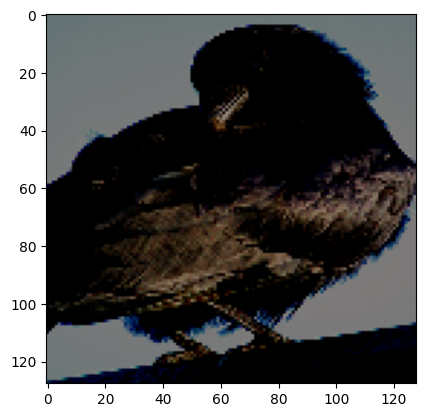

The model predicts the image belongs to class: 178


In [225]:
prediction = model.predict(image)

class_index = np.argmax(prediction)

plt.imshow(img[0])
plt.show()

print('The model predicts the image belongs to class: {}'.format(class_index))

## Model 저장하기

In [63]:
from keras.models import load_model

model.save('bird_VGG16_F1.h5')